<a href="https://colab.research.google.com/github/Gehlen05/mestrado-automacao/blob/main/algoritmo-engenharia/T1_data_gerado_alexsandro_gehlen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Description
O conjunto de dados utilizado neste experimento foi gerado de forma sintética com o objetivo de avaliar o impacto do feature engineering em modelos de regressão.
O dataset contém uma variável alvo (y) e um conjunto de variáveis independentes (X) compostas por features originais e features derivadas não lineares.

As features originais (x1, x2, x3, x4, x5) foram criadas a partir de uma distribuição normal multivariada, permitindo controlar o nível de correlação entre elas.
x6 representa uma variável original de valor elevado, associada a amplitudes mais altas e maior influência nas predições do modelo.
A variável y foi construída como uma combinação de relações lineares e não lineares das features originais, incluindo termos senoidais e interações, de forma a possibilitar a análise do ganho explicativo ao aplicar transformações.

O objetivo deste dataset é permitir a comparação entre modelos treinados apenas com as variáveis originais e modelos que incluem features de engenharia, avaliando o efeito dessas transformações nas métricas de desempenho (R² e RMSE) e na interpretabilidade via valores SHAP.

## Imports e Carregar Arquivos

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
import numpy as np
import pandas as pd

def gerar_df_xy(n=1000, d=5, tipo="senoide", rho=0.7, ruido=0.5, seed=42):
    rng = np.random.default_rng(seed)

    # matriz de covariância controlando correlação entre x1 e x2
    cov = np.eye(d)
    cov[0, 1] = cov[1, 0] = rho
    X_raw = rng.multivariate_normal(np.zeros(d), cov, size=n)
    cols = [f"x{i+1}" for i in range(d)]
    X = pd.DataFrame(X_raw, columns=cols)

    # alvo (y)
    if tipo == "linear":
        y = 2*X["x1"] - 1.3*X["x2"] + 0.4*X["x3"] + rng.normal(0, ruido, n)
    elif tipo == "senoide":
        y = np.sin(2*np.pi*X["x1"]) + 0.7*X["x2"] + rng.normal(0, ruido, n)
    elif tipo == "polinomial":
        y = (1.5*X["x1"] - 0.7*X["x2"] + 1.2*X["x1"]*X["x2"]
             + 0.8*X["x1"]**2 - 0.5*X["x3"]**2 + rng.normal(0, ruido, n))
    else:
        raise ValueError("tipo deve ser linear, senoide ou polinomial")

    # adiciona uma coluna com valores altos (para usar em bins depois)
    # distribuição log-normal gera valores positivos e assimétricos (altos)
    X[f"x{d+1}"] = np.round(rng.lognormal(mean=3.5, sigma=0.6, size=n), 2)

    # combina y + X
    df = pd.concat([pd.Series(y, name="y"), X], axis=1)
    return df



In [ ]:
# exemplo
df = gerar_df_xy(n=1000, tipo="polinomial", ruido=0.3)


In [ ]:
df.head()


,y,x1,x2,x3,x4,x5,x6
0,0.668472,0.474697,-1.036568,0.750451,0.940565,-1.039984,37.90
1,5.021037,1.530933,0.870168,-0.316243,-0.016801,0.127840,32.07
2,0.278314,-0.991830,-0.629699,0.066031,1.127241,0.777792,55.61
3,1.624752,0.811565,0.772892,-0.958883,0.878450,0.368751,47.66
4,-0.083277,0.336325,0.004544,1.222541,-0.154529,-0.680930,5.52


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1000 non-null   float64
 1   x1      1000 non-null   float64
 2   x2      1000 non-null   float64
 3   x3      1000 non-null   float64
 4   x4      1000 non-null   float64
 5   x5      1000 non-null   float64
 6   x6      1000 non-null   float64
dtypes: float64(7)
memory usage: 54.8 KB


### Análises

In [ ]:
# Ajuste: permitir passar ax para não criar figura nova sempre
def plot_enhanced_boxplot_ax(ax, data, title=""):
    median, mean, q1, q3, iqr, lower_whisker, upper_whisker, outliers = get_statistics(data)

    bp = ax.boxplot(data, vert=False, patch_artist=True, showmeans=True, meanline=True, widths=0.6)

    # Cores
    colors = {
        'box': ['#3498db'],
        'whisker': '#2c3e50',
        'mean': '#e74c3c',
        'median': '#2ecc71',
        'flier': '#e67e22'
    }
    style_boxplot(ax, bp, colors)

    ax.set_title(title, fontsize=10)
    ax.set_yticks([])
    ax.set_facecolor('#f9f9f9')



In [ ]:
def get_statistics(data):
    """Compute key statistics for the boxplot."""
    median = np.median(data)
    mean = np.mean(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = max(np.min(data), q1 - 1.5 * iqr)
    upper_whisker = min(np.max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]
    return median, mean, q1, q3, iqr, lower_whisker, upper_whisker, outliers

def style_boxplot(ax, bp, colors):
    """Apply custom styling to the boxplot elements."""
    # Style the box
    for patch, color in zip(bp['boxes'], colors['box']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor(colors['whisker'])
        patch.set_linewidth(1.5)

    # Style whiskers and caps
    for element in ['whiskers', 'caps']:
        for line in bp[element]:
            line.set_color(colors['whisker'])
            line.set_linewidth(2)

    # Style median, mean, and outliers (fliers)
    for line in bp['medians']:
        line.set_color(colors['median'])
        line.set_linewidth(3)

    for line in bp['means']:
        line.set_color(colors['mean'])
        line.set_linewidth(2)
        line.set_linestyle('--')

    for flier in bp['fliers']:
        flier.set_markerfacecolor(colors['flier'])
        flier.set_markeredgecolor(colors['whisker'])
        flier.set_markersize(8)
        flier.set_alpha(0.7)

def add_annotation(ax, annotation_positions, x_pos, text, base_y=1.2, y_offset=0, arrow=True):
    """Place an annotation smartly to avoid overlapping."""
    spacing = 0.25
    # Find nearby annotation positions to adjust the new annotation's vertical position
    nearby = [y for xpos, y in annotation_positions.items() if abs(xpos - x_pos) < 15]
    y_pos = (max(nearby) + spacing) if nearby else (base_y + y_offset)
    annotation_positions[x_pos] = y_pos

    if arrow:
        ax.annotate(text,
                    xy=(x_pos, 1),
                    xytext=(x_pos, y_pos),
                    arrowprops=dict(facecolor='#34495e', arrowstyle="->",
                                    connectionstyle="arc3,rad=.2", alpha=0.7),
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                              edgecolor='#34495e', alpha=0.8))
    else:
        ax.text(x_pos, y_pos, text,
                ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                          edgecolor='#34495e', alpha=0.8))

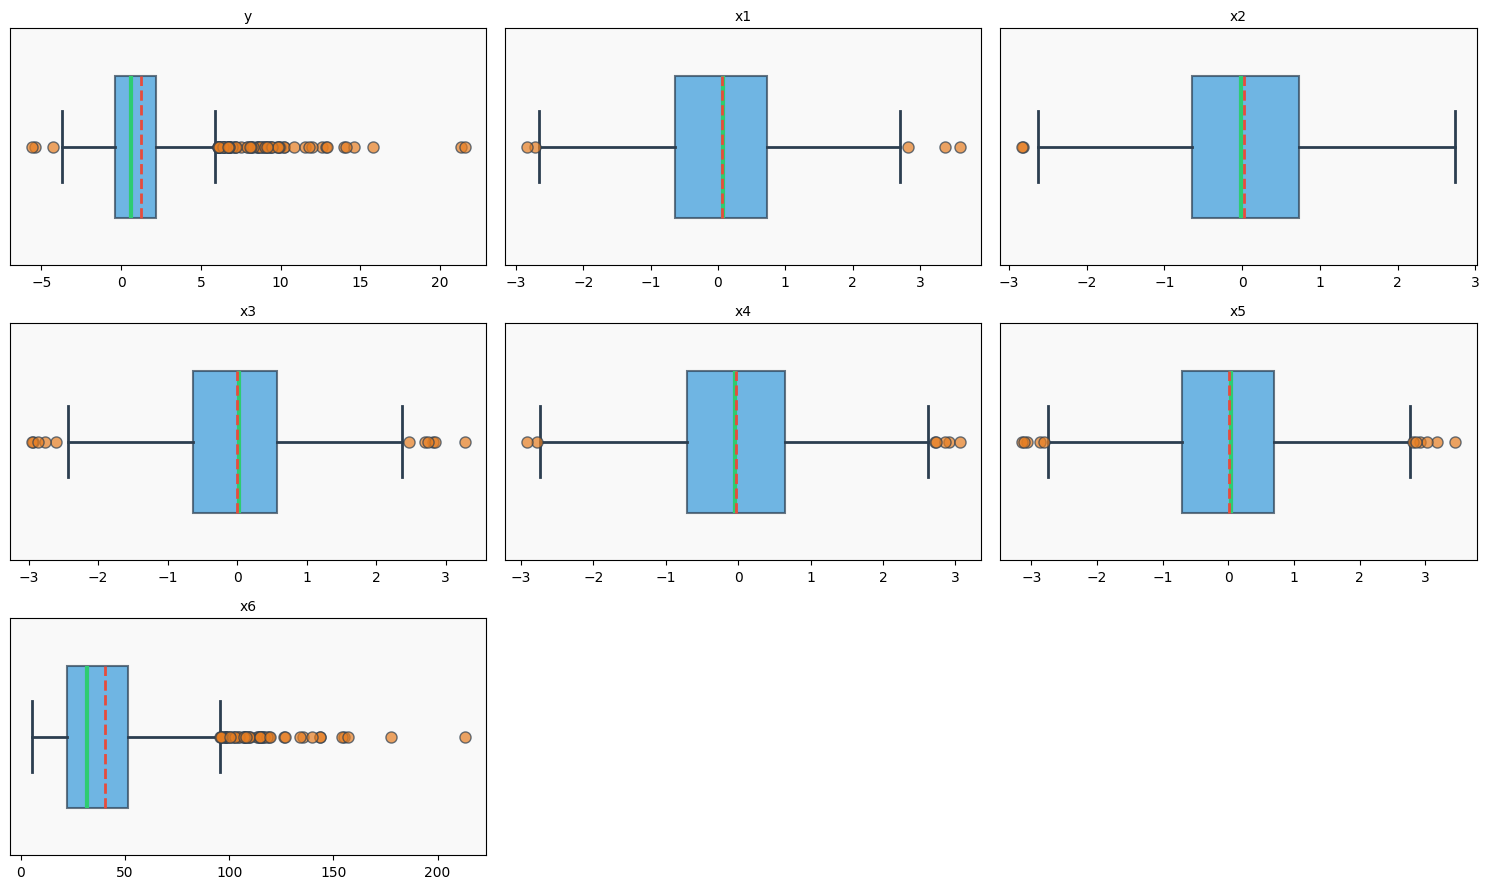

In [ ]:
# Gera boxplot
num_cols = df.select_dtypes(include="number").columns
n_cols = 3
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    serie = df[col].dropna().values
    if len(serie) == 0:
        ax.axis("off")
        continue
    plot_enhanced_boxplot_ax(ax, serie, title=col)

# Desligar eixos extras se sobrarem
for ax in axes[len(num_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


O gráfico apresenta boxplots das variáveis do dataset. As variáveis x1 a x5 exibem distribuição aproximadamente simétrica e centrada em torno de zero, sem valores extremos significativos. Já x6 possui escala mais ampla, com valores altos e presença de outliers acima de 100, indicando maior variabilidade e possíveis influências distintas sobre a variável alvo y.

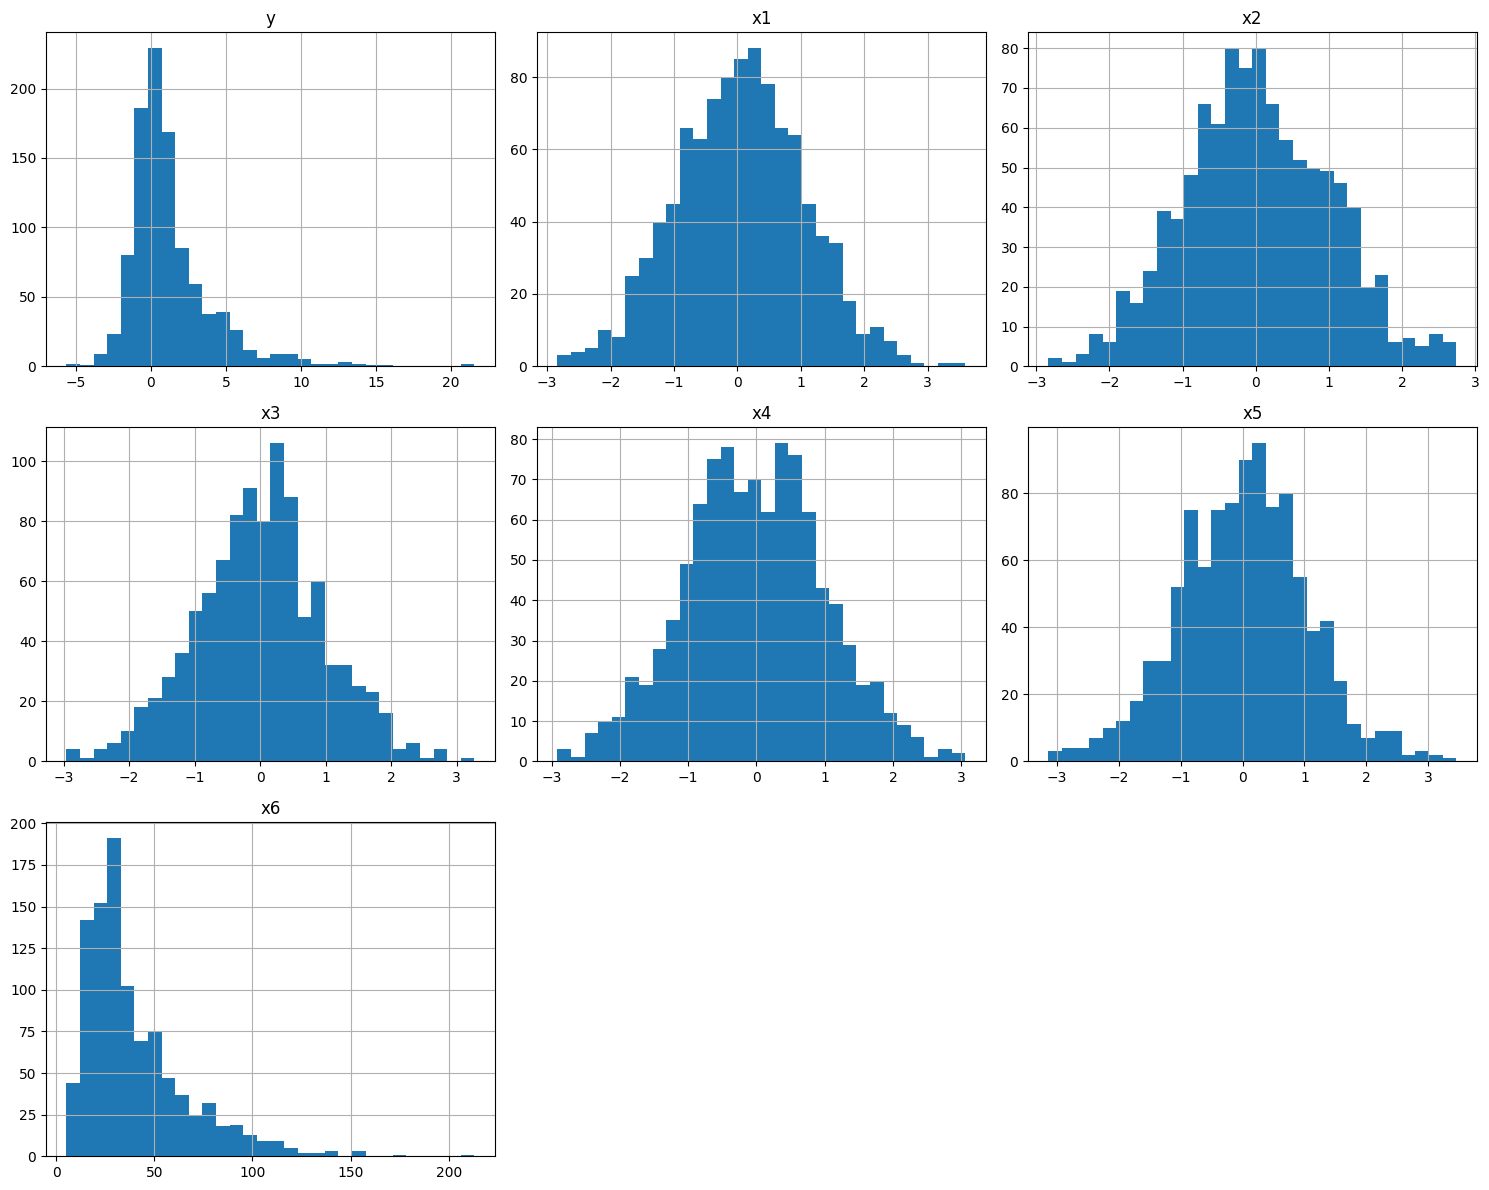

In [ ]:
# Exemplo: histograma para todas as colunas numéricas
df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

Os histogramas mostram que as variáveis x1 a x5 possuem distribuição aproximadamente normal, centrada em torno de zero e com pouca assimetria, indicando dados bem comportados. A variável x6, em contraste, apresenta forte assimetria à direita, com concentração de valores baixos e uma cauda longa até cerca de 200, caracterizando-a como a variável de maior amplitude e dispersão no conjunto. A variável alvo y também é assimétrica à direita, sugerindo que valores altos ocorrem com menor frequência.

##Transformação/Interação

In [ ]:
df_transformada = df.copy()

In [ ]:
df_transformada.columns

Index(['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'], dtype='object')

In [ ]:
cols_poly = [
    'x1', 'x2', 'x3', 'x4', 'x5'
]


# Remove NaN
df_poly_input = df_transformada[cols_poly].dropna()

# Polinômios até grau 3
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(df_poly_input)

# Nomes das novas features com prefixo
poly_names = [f"poly_{name}" for name in poly.get_feature_names_out(cols_poly)]

# DataFrame polinomial
df_poly = pd.DataFrame(poly_features, columns=poly_names, index=df_poly_input.index)

# Junta no df original (sem conflito de nomes)
df_transformada = df_transformada.join(df_poly)


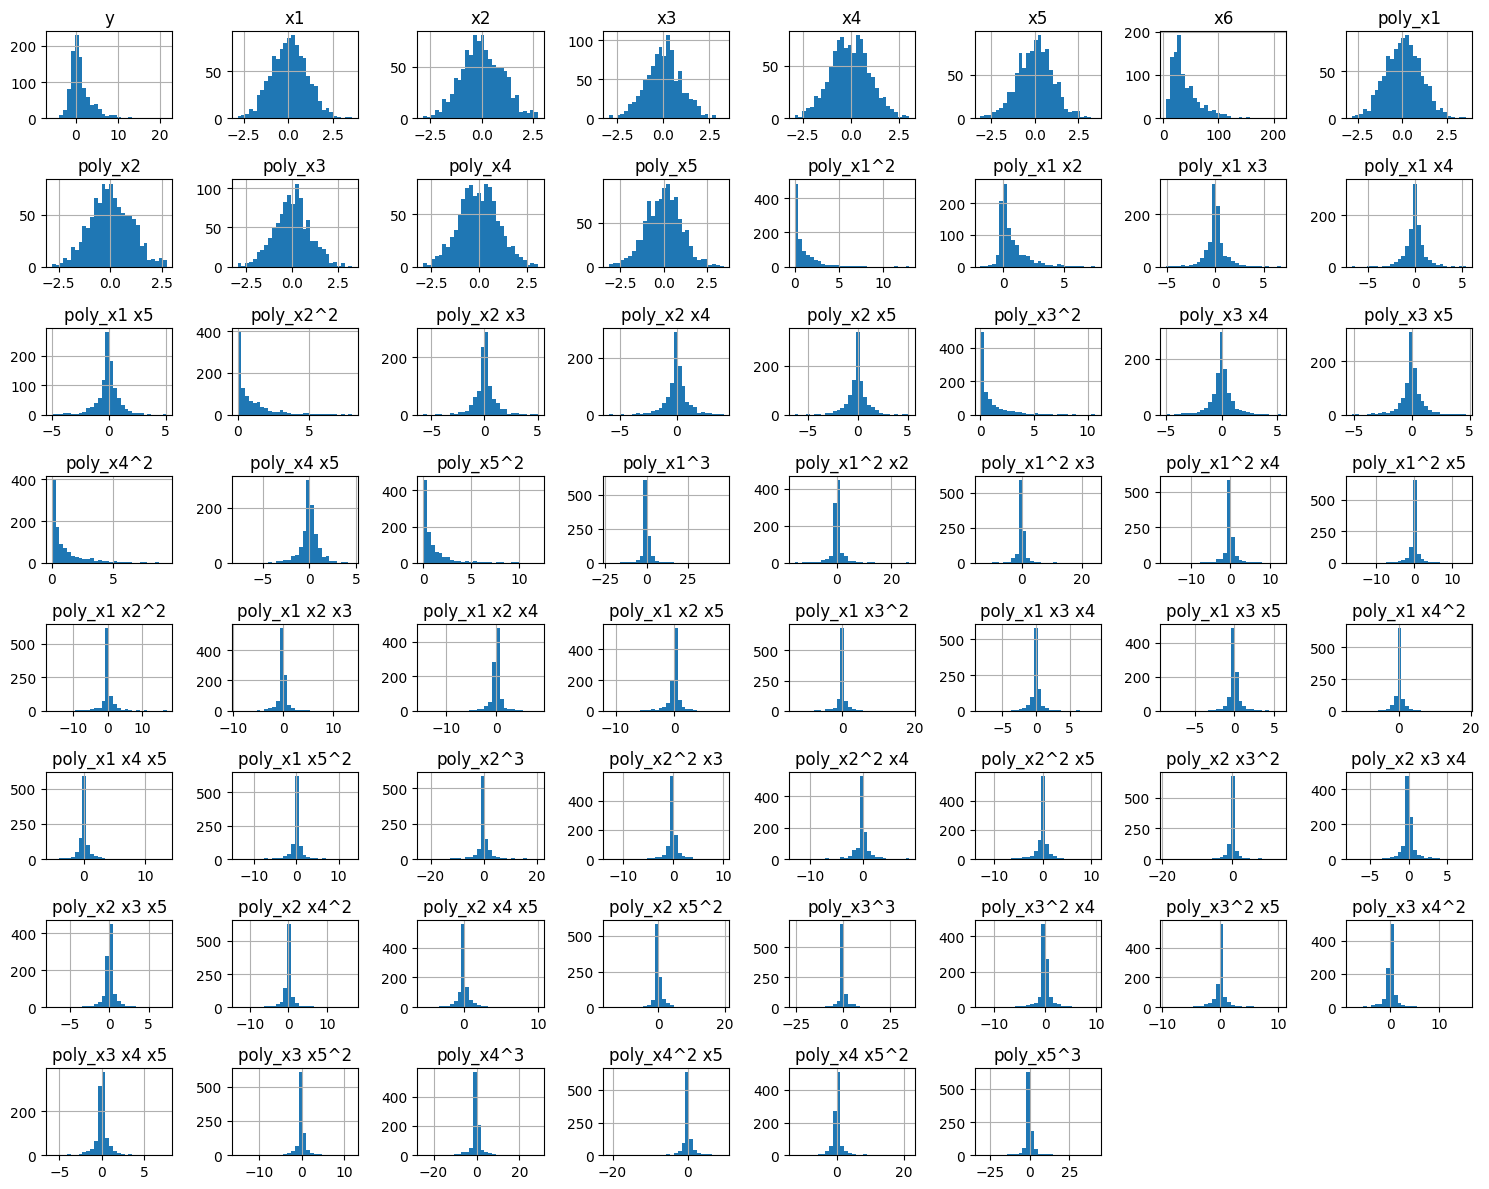

In [ ]:
df_transformada.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()


A função polinomial de grau 3 (PolynomialFeatures(degree=3)) gera novas variáveis a partir das originais, incluindo potências (ex.: x1², x1³) e interações entre elas (ex.: x1·x2, x2²·x3).
Isso permite ao modelo capturar relações não lineares e efeitos combinados entre as variáveis, ampliando sua capacidade de ajuste.
Como consequência, o modelo se torna mais flexível e pode representar padrões complexos, mas também aumenta o risco de sobreajuste e a correlação entre features, exigindo cuidado na regularização e interpretação dos resultados.

In [ ]:
df_transformada = df_transformada.drop(columns=cols_poly, axis=1)

In [ ]:
target = "y"
df_num = df_transformada.select_dtypes(include="number")
corrs = df_num.corrwith(df_num[target]).sort_values(ascending=False)
print(corrs.tail(40))


poly_x2 x3       0.122743
poly_x2 x4 x5    0.122725
poly_x2 x3^2     0.112819
poly_x1 x2 x3    0.107043
poly_x2 x4^2     0.104178
poly_x3^2 x4     0.098637
poly_x4 x5       0.083977
poly_x3 x4 x5    0.051987
poly_x2^2 x3     0.034040
poly_x3^3        0.024950
poly_x3          0.001257
poly_x3 x5^2    -0.002911
poly_x4^3       -0.008241
poly_x3 x4      -0.010524
poly_x4^2       -0.014143
poly_x4         -0.014657
poly_x5^2       -0.019440
x6              -0.027691
poly_x4^2 x5    -0.032766
poly_x2 x3 x4   -0.033206
poly_x1 x3 x4   -0.039660
poly_x3 x4^2    -0.047276
poly_x4 x5^2    -0.056797
poly_x3 x5      -0.071747
poly_x3^2 x5    -0.075592
poly_x1 x4      -0.077296
poly_x2 x4      -0.079802
poly_x5^3       -0.083037
poly_x2^2 x4    -0.084263
poly_x5         -0.106382
poly_x1^2 x4    -0.110050
poly_x2 x3 x5   -0.118188
poly_x1 x2 x4   -0.122739
poly_x1 x5      -0.134275
poly_x2 x5      -0.136051
poly_x1 x3 x5   -0.137001
poly_x3^2       -0.204121
poly_x2^2 x5    -0.235134
poly_x1 x2 x

As correlações mostram como cada feature polinomial se relaciona com a variável alvo — positivas indicam relação direta (quando a feature aumenta, o alvo tende a aumentar), enquanto negativas indicam relação inversa.

*  Maiores correlações positivas

poly_x2 x3 (0.1227) — indica uma interação moderada positiva entre x2 e x3, sugerindo que o aumento conjunto dessas variáveis tende a elevar o valor previsto.

poly_x2 x4 x5 (0.1227) — mostra um efeito combinado de três variáveis atuando na mesma direção, reforçando o padrão positivo observado em x2.

poly_x2 x3^2 (0.1128) — reforça a influência de x2 e x3, com o termo quadrático indicando sensibilidade maior para valores altos de x3.

Essas três interações envolvem principalmente x2 e x3, o que aponta para uma influência conjunta relevante dessas variáveis na resposta.

* Maiores correlações negativas

poly_x1^2 x5 (-0.2826) — mostra que quando x1 é elevado (de forma quadrática) em combinação com x5, o impacto na saída é fortemente negativo.

poly_x1 x2 x5 (-0.2756) — sugere que a interação entre x1, x2 e x5 reduz o valor previsto, indicando comportamento oposto ao das combinações com x2 e x3.

poly_x2^2 x5 (-0.2351) — reforça o papel de x5 como variável associada a efeitos negativos quando interage com termos de ordem superior de x1 e x2.

## Beans


In [ ]:
df_beans = df_transformada.copy()

Foi criada uma **variável categórica híbrida** (`feat_bin_hibrido`) a partir da coluna `x6`, dividindo seus valores em **10 faixas**: oito definidas pelos **percentis até o P80** (capturando a densidade dos valores mais frequentes) e duas adicionais para a **cauda superior** até o valor máximo. Essa abordagem permite representar melhor a variabilidade dos dados, mantendo resolução nas faixas com maior concentração e simplificando os valores extremos. Após a discretização, a coluna original `x6` foi removida e os rótulos dos bins convertidos para formato numérico.


In [ ]:
col = "x6"
max_val = df_beans.x6.max()+1

# percentis até P80 para “densidade”
pcts = df_beans[col].quantile([0, .1, .2, .3, .4, .5, .6, .7, .8]).values  # 9 pontos → 8 bins
p80 = pcts[-1]

# divide a cauda (P80..212) em 2 bins iguais (total = 8 + 2 = 10)
tail_edges = np.linspace(p80, max_val, num=3)  # 3 bordas → 2 bins

# montar bordas finais (garante monotonia e limites)
edges = np.unique(np.concatenate([pcts, tail_edges]))
edges[0] = min(edges[0], df_beans[col].min())        # inclui mínimo real
edges[-1] = max(edges[-1], max_val)            # força topo = 212

df_beans["feat_bin_hibrido"] = pd.cut(
    df_beans[col],
    bins=edges,
    include_lowest=True,
    right=True,
    labels=[str(i) for i in range(1, 11)]
)

df_beans = df_beans.drop(columns=['x6'])
#df_beans["feat_bin_hibrido"] = pd.to_numeric(df_beans["feat_bin_hibrido"], errors="coerce").astype("Int64")
df_beans["feat_bin_hibrido"] = (
    df_beans["feat_bin_hibrido"].astype(str).astype(float).astype("float64")
)




## MI HISC

In [ ]:
def mutual_information(x, y, bins=30):
    """
    Calcula MI(x, y) em bits usando histogramas 2D.
    """
    # Histogramas conjuntos
    c_xy, _, _ = np.histogram2d(x, y, bins=bins)

    # Normaliza em probabilidade
    p_xy = c_xy / np.sum(c_xy)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)

    # Evita log(0) -> filtra apenas valores > 0
    nzs = p_xy > 0
    mi = np.sum(p_xy[nzs] * np.log2(p_xy[nzs] / (p_x[:, None] * p_y[None, :])[nzs]))

    return mi


In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = df_beans.drop(columns=["y"])  # todas as features
y = df_beans["y"]

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)




In [ ]:
print(mi_series.head(20))  # top 20 features mais relacionadas

poly_x1          0.807068
poly_x1^3        0.789390
poly_x1^2 x2     0.784215
poly_x1 x2^2     0.589556
poly_x1 x2       0.587067
poly_x1^2        0.569516
poly_x2^3        0.308693
poly_x2          0.308655
poly_x1^2 x4     0.285836
poly_x1 x2 x5    0.236787
poly_x1^2 x5     0.234375
poly_x1 x2 x4    0.229110
poly_x2^2        0.213592
poly_x1^2 x3     0.202136
poly_x1 x2 x3    0.167661
poly_x1 x4       0.150933
poly_x1 x5^2     0.138973
poly_x1 x4^2     0.132185
poly_x3^2        0.108109
poly_x1 x3^2     0.103215
dtype: float64


Os resultados mostram que as maiores dependências mútua (MI) estão concentradas nas combinações envolvendo x1, indicando que essa variável e suas expansões polinomiais exercem o papel dominante na explicação da variabilidade da saída.

Principais destaques

poly_x1 (0.807) — variável com maior dependência, confirmando forte relação direta e não linear entre x1 e o alvo.

poly_x1^3 (0.789) — reforça a presença de comportamento fortemente não linear, com influência crescente para valores extremos de x1.

poly_x1^2 x2 (0.784) — mostra que x2 atua modulando o efeito quadrático de x1, indicando interação relevante entre essas duas variáveis.

Outras combinações, como poly_x1 x2 e poly_x1 x2^2, também apresentam alta dependência (>0.58), evidenciando que a interação entre x1 e x2 é central no modelo.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel

def hsic(x, y, sigma_x=None, sigma_y=None):
    """
    Calcula HSIC empírico entre dois vetores 1D (x, y).
    Usa kernel RBF com largura ajustada automaticamente.
    """
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T
    n = x.shape[0]

    # Define largura dos kernels (sigma) automaticamente se não fornecida
    if sigma_x is None:
        sigma_x = np.median(np.linalg.norm(x - np.median(x), axis=1)) or 1.0
    if sigma_y is None:
        sigma_y = np.median(np.linalg.norm(y - np.median(y), axis=1)) or 1.0

    # Matriz kernel RBF
    Kx = rbf_kernel(x, gamma=1.0 / (2 * sigma_x ** 2))
    Ky = rbf_kernel(y, gamma=1.0 / (2 * sigma_y ** 2))

    # Centralização das matrizes kernel
    H = np.eye(n) - np.ones((n, n)) / n
    Kc = H @ Kx @ H
    Lc = H @ Ky @ H

    # HSIC empírico
    hsic_value = np.trace(Kc @ Lc) / (n - 1) ** 2
    return hsic_value

def hsic_dataframe(df):
    """
    Calcula HSIC(y, xi) para todas as features numéricas do df.
    Espera uma coluna 'y' e demais colunas numéricas.
    """
    assert "y" in df.columns, "O DataFrame precisa ter a coluna 'y'."
    y = df["y"].values
    results = {}

    for col in df.drop(columns=["y"]).columns:
        x = df[col].values
        value = hsic(x, y)
        results[col] = value

    hsic_series = pd.Series(results).sort_values(ascending=False)
    print("=== Dependência HSIC (quanto maior, mais dependente de y) ===")
    print(hsic_series)
    return hsic_series



In [ ]:
hsic_scores = hsic_dataframe(df_beans)


=== Dependência HSIC (quanto maior, mais dependente de y) ===
poly_x1^2           0.031708
poly_x1             0.030864
poly_x1^3           0.029172
poly_x1 x2          0.025840
poly_x1^2 x2        0.023075
poly_x1 x2^2        0.018576
poly_x1^2 x4        0.016313
poly_x2             0.016264
poly_x1^2 x5        0.013164
poly_x1^2 x3        0.012745
poly_x1 x2 x4       0.012668
poly_x2^2           0.011902
poly_x2^3           0.011634
poly_x1 x2 x5       0.011240
poly_x1 x2 x3       0.010187
poly_x1 x4          0.008961
poly_x1 x5          0.007242
poly_x2^2 x4        0.006656
poly_x1 x3          0.006580
poly_x2^2 x5        0.005534
poly_x1 x4^2        0.005290
poly_x1 x3 x4       0.005147
poly_x2^2 x3        0.005122
poly_x1 x4 x5       0.004718
poly_x1 x5^2        0.004652
poly_x1 x3^2        0.004511
poly_x1 x3 x5       0.004304
poly_x2 x4          0.004296
poly_x3^2           0.004124
poly_x3             0.003772
poly_x2 x4^2        0.003548
poly_x3^3           0.003311
poly_x2 x5

Maiores valores de HSIC (influência positiva)

poly_x1^2 (0.0317) — o termo quadrático de x1 é o mais informativo, reforçando a presença de curvatura ou efeito não linear na relação com o alvo.

poly_x1 (0.0309) — a variável original também tem contribuição direta, com efeito linear consistente.

poly_x1^3 (0.0292) — complementa os dois anteriores, indicando comportamento cúbico relevante nos extremos de x1.

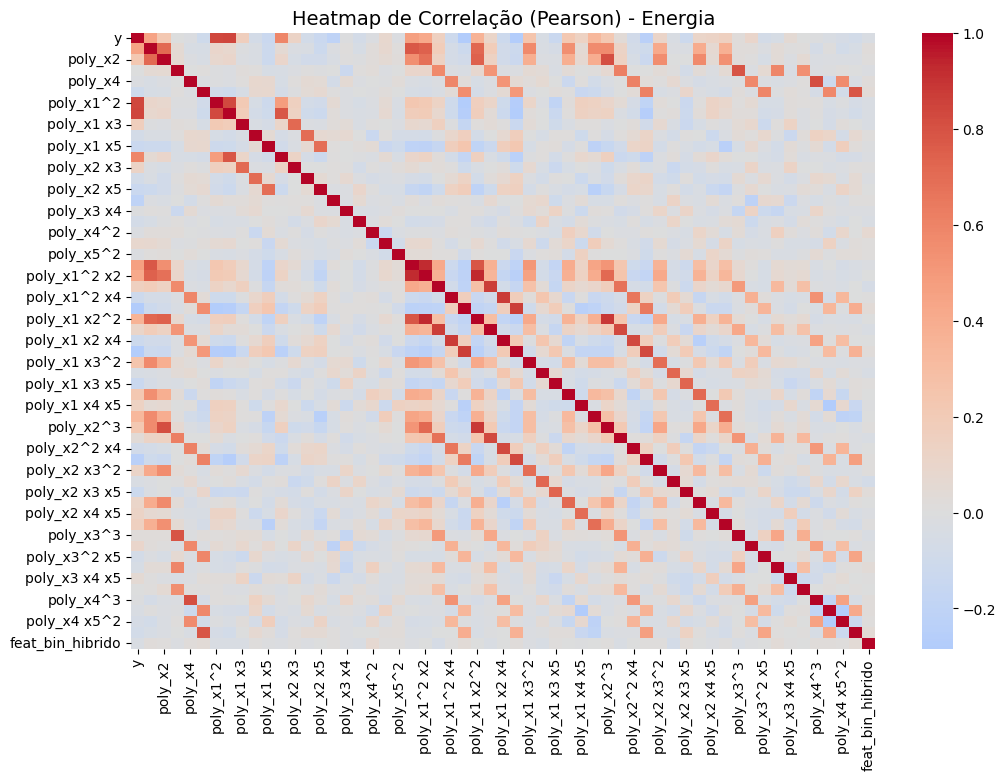

In [ ]:
# Pega apenas colunas numéricas
df_num = df_beans.select_dtypes(include="number")

# Calcula correlação de Pearson
corr = df_num.corr()

# Plota o heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Heatmap de Correlação (Pearson) - Energia", fontsize=14)
plt.show()


In [ ]:
import numpy as np
# Pegamos só a parte triangular superior (para não repetir pares)
corr_unstack = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Transformar em Series (pares → correlação)
pairs = corr_unstack.unstack().dropna()

# Ordenar pelas mais fortes
pairs_sorted = pairs.sort_values()

# Top-10 negativas
worst_pairs = pairs_sorted.head(10)

# Top-10 positivas
best_pairs = pairs_sorted.tail(10)

print("Melhores correlações (positivas):")
print(best_pairs)

print("\Melhores correlações (negativas):")
print(worst_pairs)

Melhores correlações (positivas):
poly_x2^2 x5   poly_x1 x2 x5    0.830293
poly_x2^2 x4   poly_x1 x2 x4    0.832097
poly_x1^2      y                0.835531
poly_x1 x2     y                0.844224
poly_x1 x2 x3  poly_x1^2 x3     0.871156
poly_x1 x2 x5  poly_x1^2 x5     0.871916
poly_x1 x2 x4  poly_x1^2 x4     0.879319
poly_x2^3      poly_x1 x2^2     0.882391
poly_x1^2 x2   poly_x1^3        0.928699
poly_x1 x2^2   poly_x1^2 x2     0.930801
dtype: float64
\Melhores correlações (negativas):
poly_x4^2 x5   poly_x1 x4 x5   -0.283676
poly_x1^2 x5   y               -0.282571
poly_x1 x2 x5  poly_x1 x2      -0.276222
               y               -0.275622
poly_x1^2 x5   poly_x1^2       -0.273142
poly_x4 x5^2   poly_x4^2 x5    -0.272812
poly_x1 x2 x5  poly_x1^2       -0.266126
poly_x1^2 x5   poly_x1 x2      -0.261457
poly_x2^2 x5   poly_x1 x2      -0.254413
poly_x1 x5^2   poly_x2 x5      -0.246391
dtype: float64


<>:20: SyntaxWarning: invalid escape sequence '\M'
<>:20: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-1198263295.py:20: SyntaxWarning: invalid escape sequence '\M'
  print("\Melhores correlações (negativas):")


## Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
TARGET = "y"
df_ = df.copy()
y = df[TARGET].to_numpy()
X = df_.drop(columns=[TARGET])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
df_ = df_beans.copy()
y_f = df_[TARGET].to_numpy()
X_f = df_.drop(columns=[TARGET])

X_train_f, X_test_f, y_train, y_test = train_test_split(
    X_f, y_f, test_size=0.30, random_state=42, shuffle=True
)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# predições
y_pred = model.predict(X_test)

# métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



In [ ]:
print("=== Resultados Regressão Linear ===")
print(f"R²  : {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

=== Resultados Regressão Linear ===
R²  : 0.2458
RMSE: 2.3431


In [ ]:

model_f = LinearRegression()
model_f.fit(X_train_f, y_train)

# predições
y_pred_f = model_f.predict(X_test_f)

# métricas
r2 = r2_score(y_test, y_pred_f)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_f))



In [ ]:
print("=== Resultados Regressão Linear ===")
print(f"R²  : {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

=== Resultados Regressão Linear ===
R²  : 0.9869
RMSE: 0.3088


In [ ]:

print("MAE valid:", mean_absolute_error(y_test, model.predict(X_test)))


MAE valid: 1.6841718327288917


In [ ]:
print("MAE valid:", mean_absolute_error(y_test, model_f.predict(X_test_f)))


MAE valid: 0.2454769679020501


Após a aplicação do feature engineering (geração de variáveis polinomiais e discretização híbrida de x6), o modelo apresentou melhora expressiva de desempenho em relação à versão original:

R² aumentou de 0.2458 → 0.9869, indicando que o modelo passou a explicar praticamente toda a variabilidade da variável alvo.

RMSE reduziu de 2.34 → 0.31, mostrando erro médio quadrático muito menor e previsões mais próximas dos valores reais.

MAE também diminuiu significativamente (de 1.68 → 0.25), reforçando a redução do erro absoluto médio.

Esses resultados evidenciam que o feature engineering permitiu capturar relações não lineares e interações entre variáveis, antes não modeladas pela regressão linear simples. Assim, o modelo passou de um comportamento subajustado para um ajuste muito mais representativo dos dados.

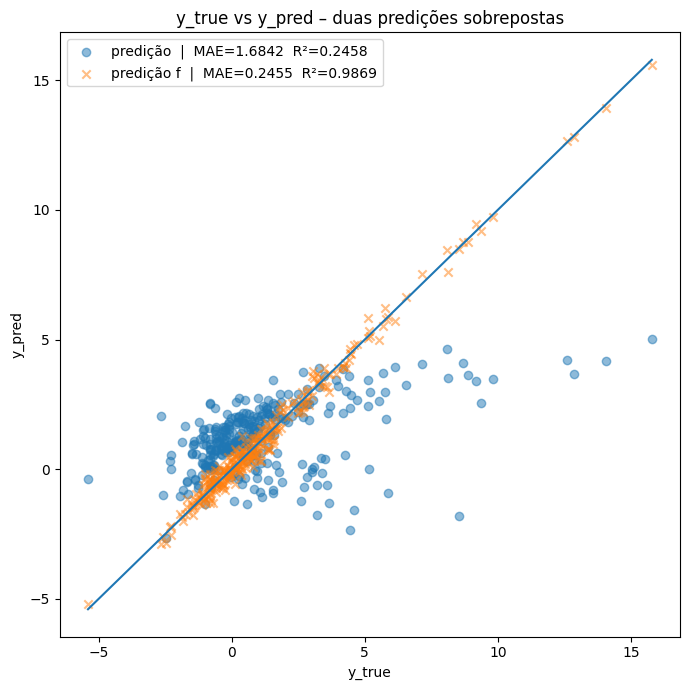

Figura salva em: y_true_vs_pred_duas_series.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def plot_duas_predicoes(y_true_a, y_pred_a, y_true_b, y_pred_b,
                        label_a="predição", label_b="predição f",
                        fname="y_true_vs_pred_duas_series.png"):
    # Array 1D e remove NaN/inf
    def _clean(y_t, y_p):
        y_t = np.asarray(y_t).reshape(-1)
        y_p = np.asarray(y_p).reshape(-1)
        m = np.isfinite(y_t) & np.isfinite(y_p)
        return y_t[m], y_p[m]

    y_t_a, y_p_a = _clean(y_true_a, y_pred_a)
    y_t_b, y_p_b = _clean(y_true_b, y_pred_b)


    # Métricas
    mae_a = mean_absolute_error(y_t_a, y_p_a)
    r2_a  = r2_score(y_t_a, y_p_a)

    mae_b = mean_absolute_error(y_t_b, y_p_b)
    r2_b  = r2_score(y_t_b, y_p_b)

    # Limites globais
    mn = float(min(y_t_a.min(), y_p_a.min(), y_t_b.min(), y_p_b.min()))
    mx = float(max(y_t_a.max(), y_p_a.max(), y_t_b.max(), y_p_b.max()))

    # Gráfico único (sem subplots), sem definir cores manualmente
    plt.figure(figsize=(7, 7))
    plt.scatter(y_t_a, y_p_a, alpha=0.5, label=f"{label_a}  |  MAE={mae_a:.4f}  R²={r2_a:.4f}")
    plt.scatter(y_t_b, y_p_b, alpha=0.5, marker="x", label=f"{label_b}  |  MAE={mae_b:.4f}  R²={r2_b:.4f}")
    plt.plot([mn, mx], [mn, mx], linewidth=1.5)  # linha y=x
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.title("y_true vs y_pred – duas predições sobrepostas")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Figura salva em: {fname}")

# ---- Exemplo com suas variáveis ----
# Conjunto "f"
y_true_f = np.asarray(y_test)
y_pred_f = model_f.predict(X_test_f)

# Conjunto "normal"
y_true = np.asarray(y_test)
y_pred = model.predict(X_test)

plot_duas_predicoes(
    y_true, y_pred,
    y_true_f, y_pred_f,
    label_a="predição",
    label_b="predição f",
    fname="y_true_vs_pred_duas_series.png"
)


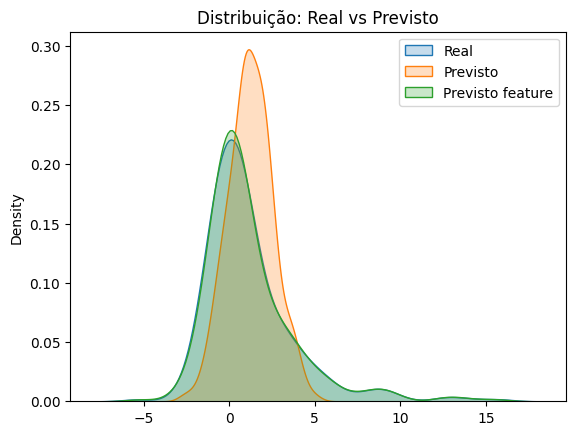

In [ ]:
sns.kdeplot(y_test, label="Real", fill=True)
sns.kdeplot(y_pred, label="Previsto", fill=True)
sns.kdeplot(y_pred_f, label="Previsto feature", fill=True)
#sns.kdeplot(y_pred_r, label="Previsto feature reduzido", fill=True)
plt.title("Distribuição: Real vs Previsto")
plt.legend()
plt.show()


As duas imagens demonstram de forma clara o impacto positivo do feature engineering na performance do modelo de regressão linear.

Na primeira figura (y_true vs y_pred), observa-se que o modelo original (pontos azuis) apresenta grande dispersão em torno da linha de identidade, evidenciando erros consideráveis e subajuste. Já o modelo com features polinomiais e discretização de x6 (pontos laranja) mostra alinhamento quase perfeito com a linha ideal, indicando previsões precisas e alta correlação com os valores reais.

Na segunda figura (Distribuição: Real vs Previsto), nota-se que a curva verde — referente ao modelo com feature engineering — praticamente se sobrepõe à distribuição real, enquanto a curva laranja (modelo simples) apresenta deslocamento e menor aderência.

Esses resultados confirmam que a transformação das variáveis permitiu capturar relações não lineares e interações complexas, resultando em uma melhor aproximação das predições em relação aos valores reais, com aumento expressivo do R² e redução substancial dos erros (RMSE e MAE).

In [ ]:
# Instalação (se faltar)
# pip install shap matplotlib

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

def shap_para_regressao_linear(model, X_train, X_test, top_k=3):
    """
    Calcula e plota SHAP para um modelo LinearRegression já treinado.
    - model: sklearn.linear_model.LinearRegression treinado
    - X_train: DataFrame de treino (usado como background para o SHAP)
    - X_test: DataFrame de teste (usado nos gráficos)
    - top_k: nº de features p/ dependence plots
    """
    assert hasattr(model, "predict"), "model deve ter método .predict"
    assert isinstance(X_train, (pd.DataFrame, np.ndarray)), "X_train deve ser DataFrame/array"
    assert isinstance(X_test, (pd.DataFrame, np.ndarray)), "X_test deve ser DataFrame/array"

    # SHAP para modelos lineares: LinearExplainer (rápido e estável)
    explainer = shap.LinearExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)   # (n_amostras, n_features)

    # Para facilitar: nomes de features
    feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f"f{i}" for i in range(X_test.shape[1])]

    # ======== Plot 1: Importância global (bar) ========
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Linear Regression)")
    plt.tight_layout()
    plt.show()

    # ======== Plot 2: Beeswarm ========
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title("SHAP Beeswarm (Linear Regression)")
    plt.tight_layout()
    plt.show()

    # ======== Plot 3: Dependence plots para top-k ========
    mean_abs = np.abs(shap_values).mean(axis=0)
    top_idx = np.argsort(-mean_abs)[:top_k]
    for i in top_idx:
        feat = feature_names[i]
        plt.figure()
        shap.dependence_plot(feat, shap_values, X_test, feature_names=feature_names, show=False)
        plt.title(f"SHAP Dependence: {feat}")
        plt.tight_layout()
        plt.show()

    # Retorna importâncias numéricas também
    importances = pd.Series(mean_abs, index=feature_names).sort_values(ascending=False)
    return {
        "explainer": explainer,
        "shap_values": shap_values,
        "feature_importance": importances
    }



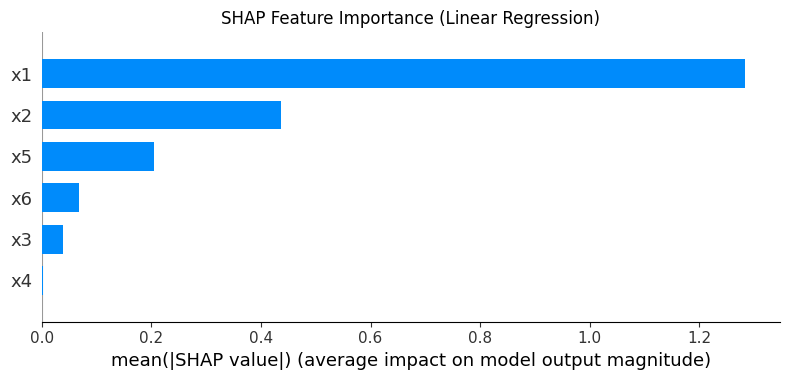

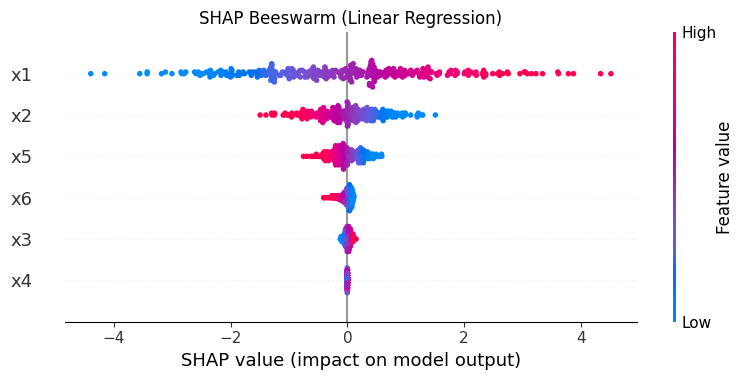

<Figure size 640x480 with 0 Axes>

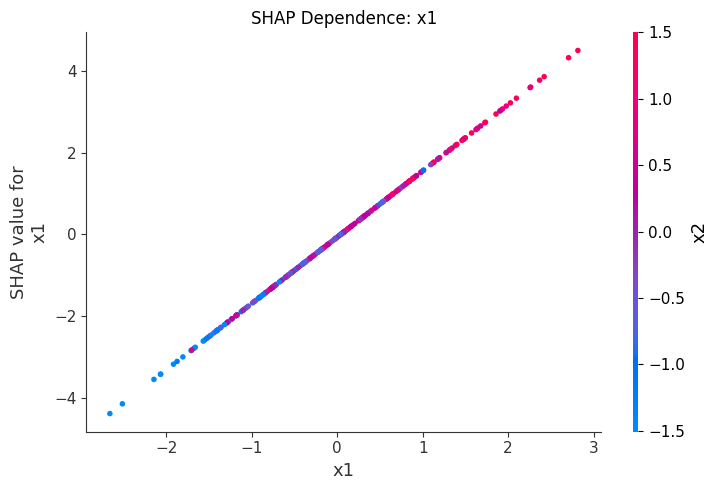

<Figure size 640x480 with 0 Axes>

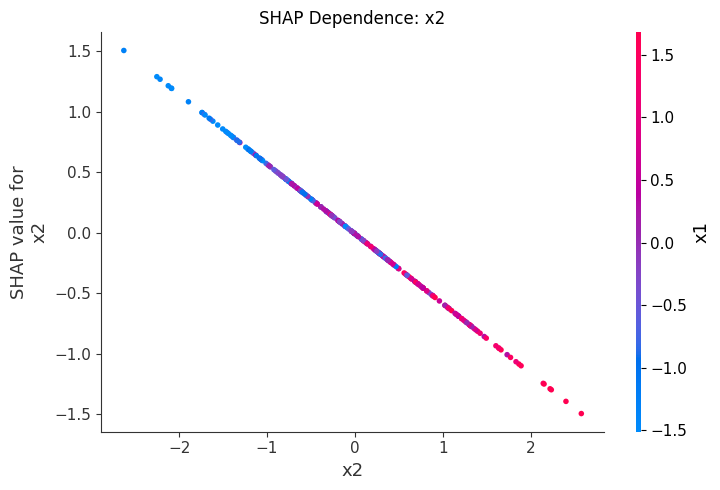

<Figure size 640x480 with 0 Axes>

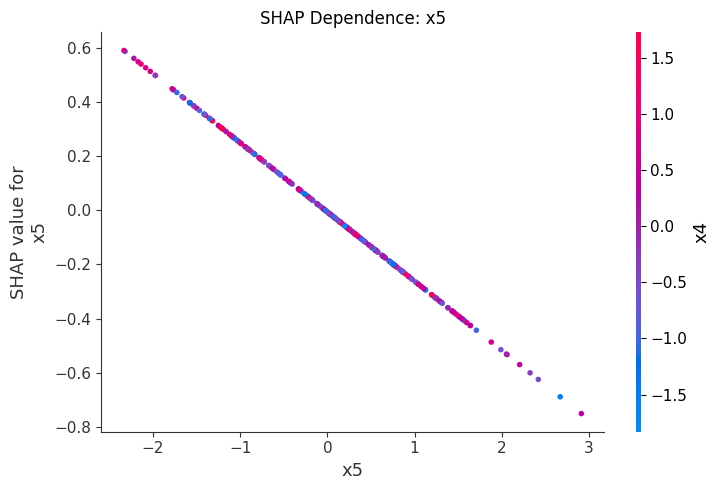

In [ ]:
res = shap_para_regressao_linear(model, X_train, X_test, top_k=3)


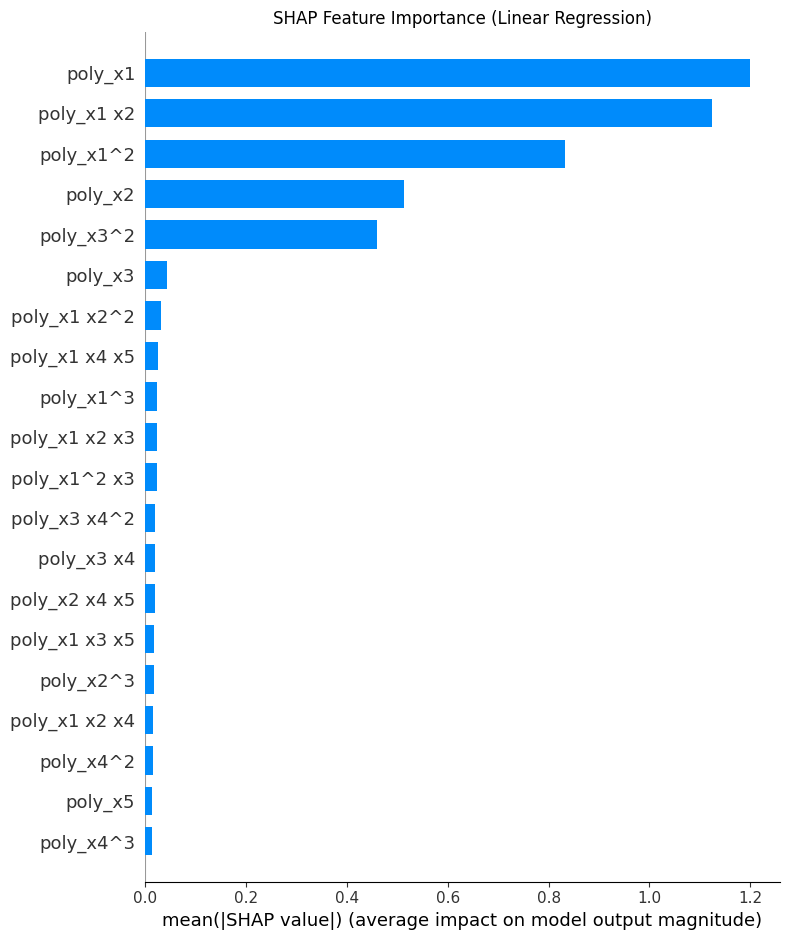

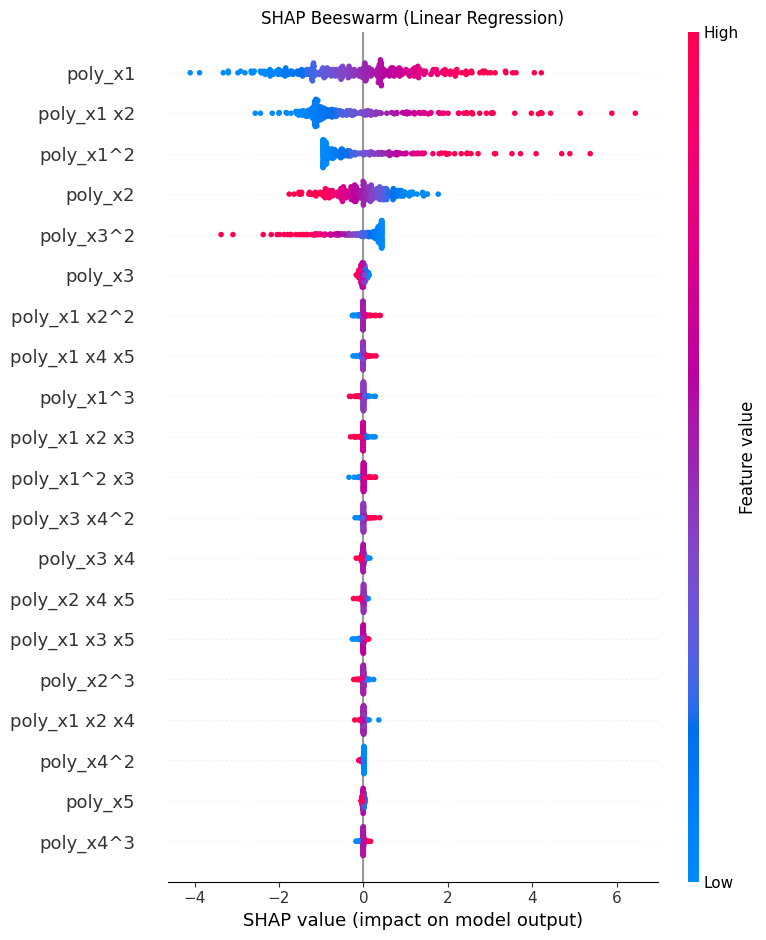

<Figure size 640x480 with 0 Axes>

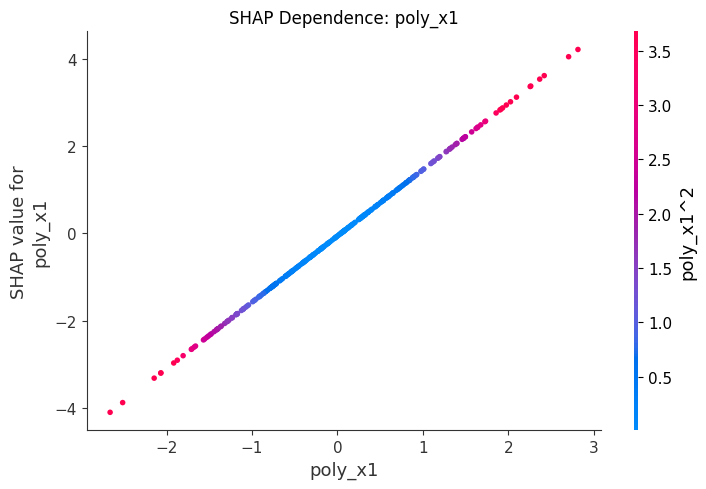

<Figure size 640x480 with 0 Axes>

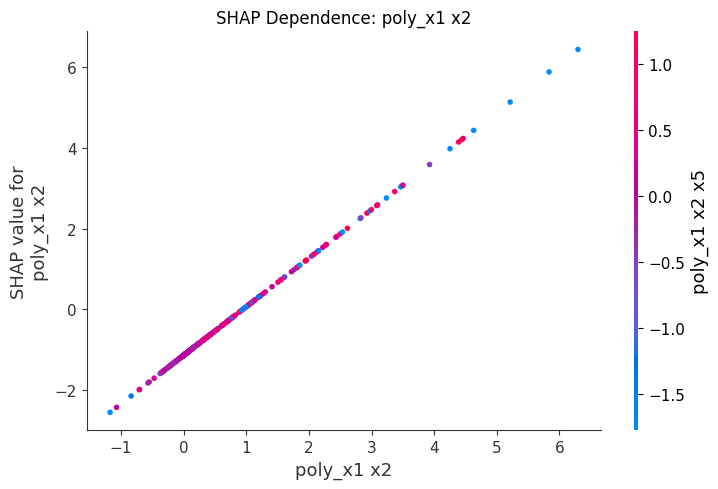

<Figure size 640x480 with 0 Axes>

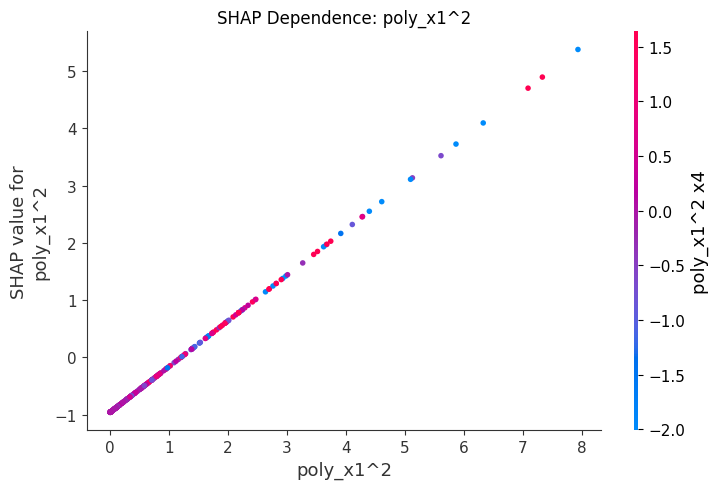

In [ ]:
res = shap_para_regressao_linear(model_f, X_train_f, X_test_f, top_k=3)

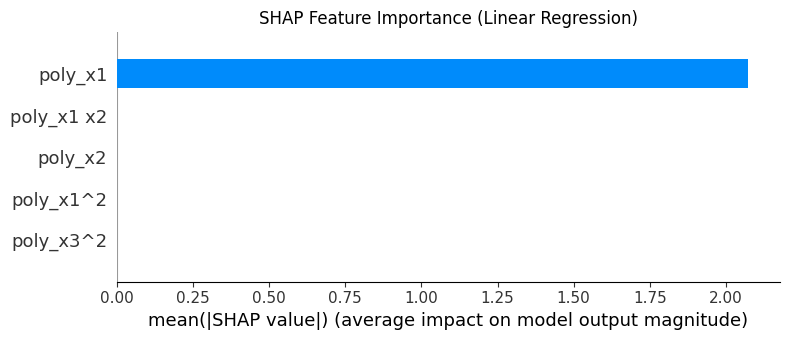

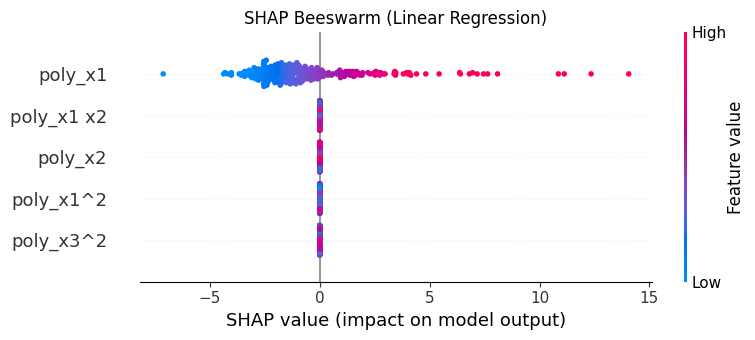

<Figure size 640x480 with 0 Axes>

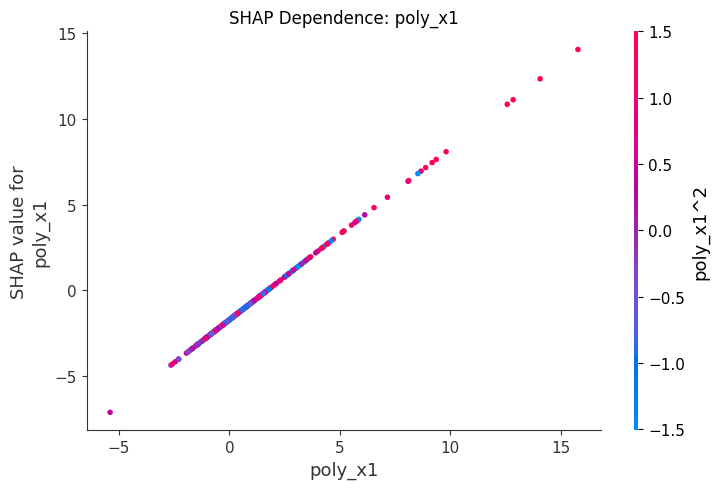

<Figure size 640x480 with 0 Axes>

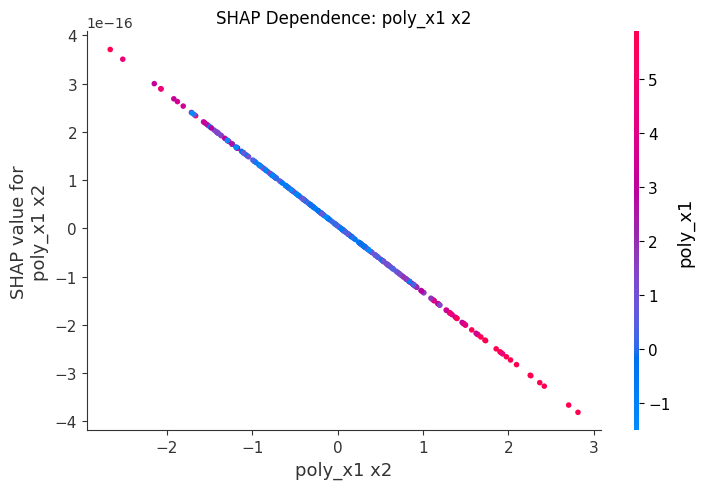

<Figure size 640x480 with 0 Axes>

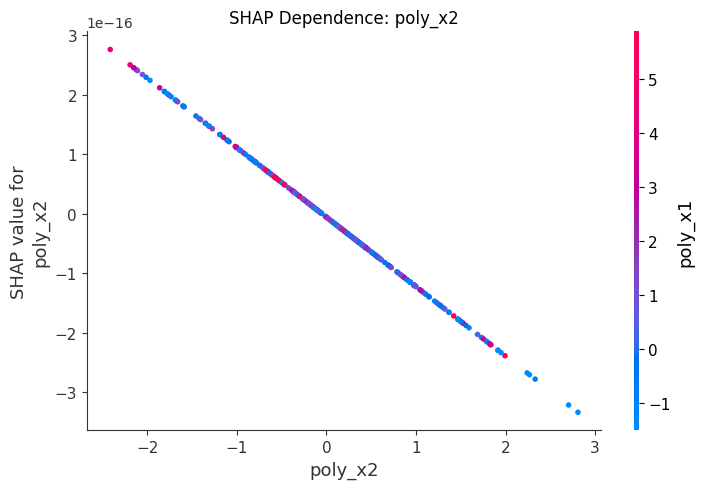

In [ ]:
res = shap_para_regressao_linear(model_r, X_train_r, X_test_r, top_k=3)

O comparativo entre os dois gráficos SHAP Beeswarm (antes e depois do feature engineering) evidencia claramente a mudança no padrão de importância e no comportamento das variáveis após a transformação das features.

No modelo original, observa-se que as variáveis x1 e x2 são as mais relevantes, com impactos lineares mais simples sobre o resultado, enquanto x3, x4, x5 e x6 exercem pouca influência. O modelo depende essencialmente de relações diretas e lineares.

Após o feature engineering (com inclusão de termos polinomiais e discretização de x6), o gráfico mostra uma redistribuição da importância entre as variáveis derivadas, especialmente nas combinações envolvendo x1 e x2. As interações e potências capturam efeitos não lineares antes invisíveis, o que explica o ganho expressivo de desempenho (R² de 0.24 → 0.98).